<a href="https://colab.research.google.com/github/aquibjaved/Image-search/blob/master/image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Installing PyDrive to access google drive 
!pip install PyDrive


    100% |████████████████████████████████| 993kB 7.4MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Now, you have to authorize Google SDK to access Google Drive from Colab. 
# First, execute the following commands:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Downloading the file
download = drive.CreateFile({'id': '1IumdLjTSkRL-DZLxMySPZIZL6keePYX_'})
download.GetContentFile('DOWNLOAD.tar')

In [5]:
!unzip DOWNLOAD.tar

Archive:  DOWNLOAD.tar
   creating: fashionMnist/
   creating: fashionMnist/.ipynb_checkpoints/
  inflating: fashionMnist/.ipynb_checkpoints/svm_fashion_mnist-checkpoint.ipynb  
   creating: fashionMnist/data/
  inflating: fashionMnist/data/fashion-mnist_test.csv  
  inflating: fashionMnist/data/fashion-mnist_train.csv  
  inflating: fashionMnist/svm_fashion_mnist.ipynb  


In [0]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from random import randint

In [0]:
data_train = pd.read_csv("/content/fashionMnist/data/fashion-mnist_train.csv")
data_test = pd.read_csv("/content/fashionMnist/data/fashion-mnist_test.csv")
# Labels 
labels_map = {  0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot" }

In [0]:
## recreate the train_x array and val_x array
train_x = data_train[list(data_train.columns)[1:]].values
# train_x, val_x = train_test_split(train_x, test_size=0.2)
val_x = data_test[list(data_test.columns)[1:]]
## normalize and reshape
train_x = np.array(train_x/255.)
val_x = np.array(val_x/255.)

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

noise_factor = 0.5
train_x_noisy = train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape) 
val_x_noisy = val_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_x.shape) 

train_x_noisy = np.clip(train_x_noisy, 0., 1.)
val_x_noisy = np.clip(val_x_noisy, 0., 1.)

train_x_noisy = train_x_noisy.reshape(-1, 28, 28, 1)
val_x_noisy = val_x_noisy.reshape(-1, 28, 28, 1)

In [0]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = BatchNormalization()(encoded_layer1)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = BatchNormalization()(encoded_layer2)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)

encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
encoded_layer3 = BatchNormalization()(encoded_layer3)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = BatchNormalization()(decoded_layer1)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = BatchNormalization()(decoded_layer2)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = BatchNormalization()(decoded_layer3)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [31]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_noisy, train_x, epochs=15, batch_size=2048, validation_data=(val_x_noisy, val_x), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 14s 229us/step - loss: 0.3664 - val_loss: 0.6768
Epoch 2/15
60000/60000 [==============================] - 12s 200us/step - loss: 0.0617 - val_loss: 0.1943
Epoch 3/15
60000/60000 [==============================] - 12s 199us/step - loss: 0.0455 - val_loss: 0.1037
Epoch 4/15
60000/60000 [==============================] - 12s 199us/step - loss: 0.0406 - val_loss: 0.0738
Epoch 5/15
60000/60000 [==============================] - 12s 199us/step - loss: 0.0378 - val_loss: 0.0581
Epoch 6/15
60000/60000 [==============================] - 12s 199us/step - loss: 0.0358 - val_loss: 0.0539
Epoch 7/15
60000/60000 [==============================] - 12s 198us/step - loss: 0.0345 - val_loss: 0.0447
Epoch 8/15
60000/60000 [==============================] - 12s 200us/step - loss: 0.0332 - val_loss: 0.0452
Epoch 9/15
60000/60000 [==============================] - 12s 200us/step - loss: 0.0324 - val_

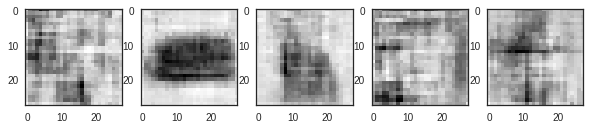

In [33]:
preds = model_2.predict(val_x[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(10, 10)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()